In [15]:
import os
import pandas as pd
import numpy as np

# Set the path to the folder containing Excel files
folder_path = "/Users/marclambertes/Downloads/Wyscout Database"

# Container for all player data
all_data = []

# Loop through all Excel files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".xlsx"):
        file_path = os.path.join(folder_path, filename)
        try:
            xls = pd.ExcelFile(file_path)
            if 'Search results (500)' in xls.sheet_names:
                df = xls.parse('Search results (500)')
                df['Source File'] = filename
                all_data.append(df)
        except Exception as e:
            print(f"Error reading {filename}: {e}")

# Combine into a single DataFrame
if not all_data:
    raise ValueError("No valid Excel files found.")
combined_df = pd.concat(all_data, ignore_index=True)

# Filter out goalkeepers
# Filter for outfield players with Position including 'CF' and at least 500 minutes played
df_outfield = combined_df[
    (combined_df['Position'].str.contains('CF', na=False)) &
    (combined_df['Minutes played'] >= 500)
]

# Select necessary columns
cols = ['Player', 'Team', 'xG per 90', 'Goals per 90', 'Source File']
df_analysis = df_outfield[cols].dropna()

# Calculate anomaly score
df_analysis['Anomaly Score'] = df_analysis['Goals per 90'] - df_analysis['xG per 90']

# Define anomaly threshold (customizable)
anomaly_threshold = 0.25
low_xg_threshold = 0.4

# Flag anomalies
anomalies = df_analysis[
    (df_analysis['Anomaly Score'] > anomaly_threshold) & 
    (df_analysis['xG per 90'] < low_xg_threshold)
]

# Save results
output_path = os.path.join(folder_path, "xg_goals_per90_anomalies.xlsx")
anomalies.to_excel(output_path, index=False)

print(f"Anomalies saved to: {output_path}")


Error reading ~$xg_goals_per90_anomalies.xlsx: Excel file format cannot be determined, you must specify an engine manually.
Anomalies saved to: /Users/marclambertes/Downloads/Wyscout Database/xg_goals_per90_anomalies.xlsx


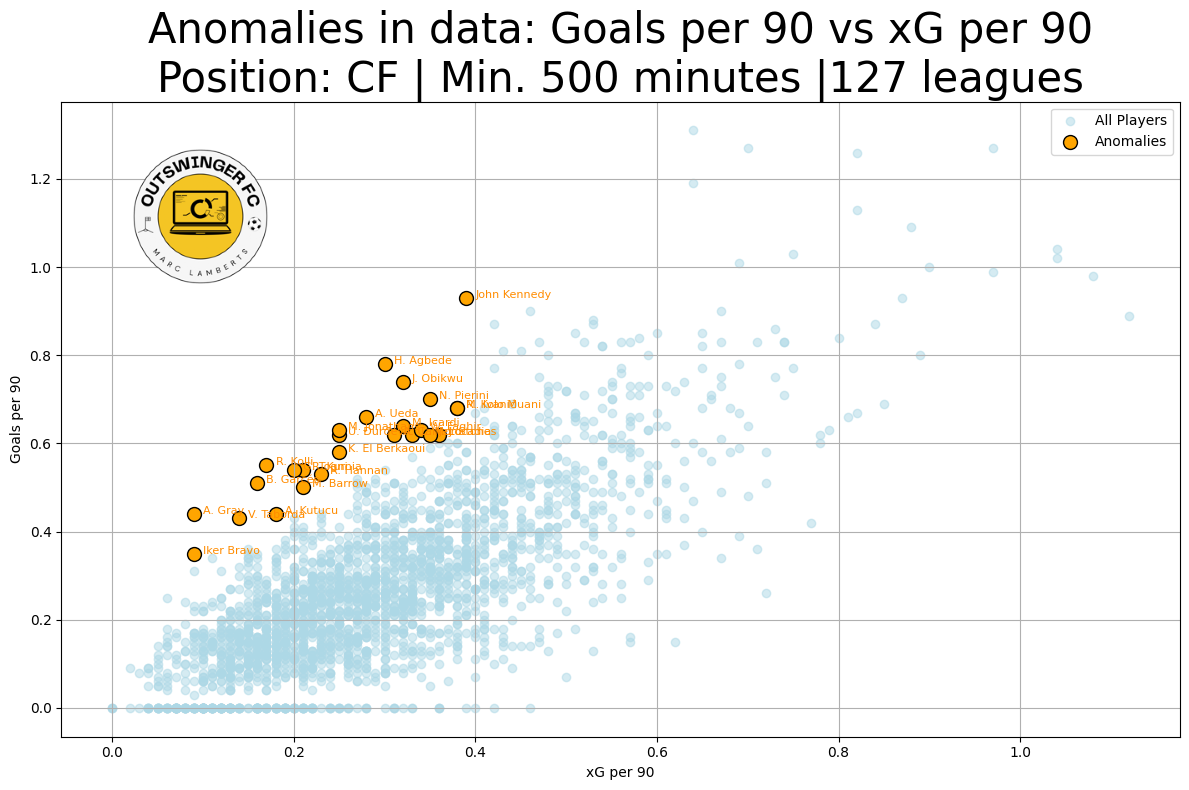

In [22]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Load your logo (update the path to your actual image)
logo_path = "Data visuals/Outswinger FC (3).png"
logo_img = mpimg.imread(logo_path)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Scatter plot: All players
ax.scatter(df_analysis['xG per 90'], df_analysis['Goals per 90'],
           alpha=0.5, label='All Players', color='lightblue')

# Highlight anomalies
ax.scatter(anomalies['xG per 90'], anomalies['Goals per 90'],
           color='orange', label='Anomalies', edgecolor='black', s=100)

# Add labels for anomalies
for _, row in anomalies.iterrows():
    ax.text(row['xG per 90'] + 0.01, row['Goals per 90'], row['Player'], fontsize=8, color='darkorange')

# Add logo to top-left
imagebox = OffsetImage(logo_img, zoom=0.6)
ab = AnnotationBbox(imagebox, (0.05, 0.95), xycoords='axes fraction',
                    frameon=False, box_alignment=(0, 1))
ax.add_artist(ab)

# Labels and styling
ax.set_xlabel('xG per 90')
ax.set_ylabel('Goals per 90')
ax.set_title('Anomalies in data: Goals per 90 vs xG per 90\nPosition: CF | Min. 500 minutes |127 leagues', fontsize=30)
ax.legend()
ax.grid(True)
plt.tight_layout()

# Show the plot
plt.show()
